In [67]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [68]:
# Initialize notebook: imports and plot style config
%run init.py

Current time: 2020-08-24 07:17:59.426137


In [69]:
# source and format dataset
url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv'
data = pd.read_csv(url)

# rename columns
data = data.rename(columns={
    'Date': 'date',
    'Country/Region': 'location',
    'Province/State': 'region',
    'Confirmed': 'cases',
    'Recovered': 'recovered',
    'Deaths': 'deaths',
})

# dates to datetime
data['date'] = data['date'].map(lambda date: datetime.datetime.strptime(date, '%Y-%m-%d'))

# format region naming
def format_region(row):
    if row['region'] is np.nan:
        return row['location']
    else:
        return row['region']
data['region'] = data.apply(format_region, axis=1)



    
# add missing overall data for country
for country in data[data.region!=data.location].location.unique():
    if (country in data[data.location==country].region.unique())==False:
        df = data[data.location==country].groupby(['location', 'date'],as_index=False).sum()
        df['region'] = country
        data = data.append(df, ignore_index=True)
        
        

# dictionary of population
population = {
    'Hubei': 56e6,
    'Korea, South': 54.5e6,
    #'Japan': 127e6,
    #'Iran': 81e6,
    'Australia': 24.6e6,
    'US': 327e6,
    #'Switzerland': 8.5e6,
    #'Austria': 8.8e6,
    #'Germany': 82.7e6,
    #'France': 67e6,
    #'United Kingdom': 66.5e6,
    #'Spain': 46.6e6,
    #'San Marino': 33.7e3,
    #'Italy': 60e6,
    'Hong Kong': 7.392e6,
    'Canada': 37.59e6,
}
popdf = pd.read_csv('dataframes/world_population.csv')    
for state in data.region.unique():
    try: 
        data.at[data.region==state, 'population'] = popdf[popdf.location==state].population.iat[0]
    except:
        continue
for state in population.keys():
    if state not in list(popdf.location): 
        data.at[data.region==state, 'population'] = population[state]
data['population'] = data['population'].replace(np.nan, 9999999999)
data = data.replace(np.nan,0.0000000001)

# add differential columns
for col in ['cases', 'recovered', 'deaths']:
    data['new_'+col] = data[col].diff()

        
# relative increment (averaged over 1, 2, 3, 4 days)
for var in ['cases', 'deaths', 'recovered']: 
    for dayspan in [1,2,3,4]:
        colname = var+'_delta'+str(dayspan)
        data[colname] = 0
        for i in np.arange(dayspan):
            data[colname] = data[colname] + data['new_'+var].shift(i)/data[var].shift(i+1)
        data[colname] = data[colname]/dayspan
        #data[colname] = data[colname].map('{:.1e}'.format)

# add date per 100k inhabitants
for var in ['cases','new_cases','deaths','new_deaths','recovered','new_recovered']:
    data[var+'_per100k'] = data.apply(lambda row: row[var]/row.population*1e5, axis = 1)
    
# ordering and casting/formatting columns   
data = data[['date','region','cases','new_cases','deaths','new_deaths','recovered','new_recovered','population',
             'cases_per100k','new_cases_per100k','deaths_per100k','new_deaths_per100k','recovered_per100k','new_recovered_per100k',
             'cases_delta1','cases_delta2','cases_delta3','cases_delta4',
             'deaths_delta1','deaths_delta2','deaths_delta3','deaths_delta4',
             'recovered_delta1','recovered_delta2','recovered_delta3','recovered_delta4',
            ]]
data = data.replace(np.nan,0.0000000001)
data[['cases','new_cases','deaths','new_deaths','recovered','new_recovered','population']] = data[['cases','new_cases','deaths','new_deaths','recovered','new_recovered','population']].astype(int)

data['weekid'] = data['date'].map(lambda date: date.isocalendar()[1]+date.year*100)
data_weekly = data.groupby(['region','weekid'],as_index=False).sum()
data_weekly['date'] = data_weekly['weekid'].map(lambda weekid: datetime.datetime.strptime('%04d-%02d-1' % (int(weekid/100), weekid-int(weekid/100)*100), '%G-%V-%w').date()+timedelta(days=6))
data_weekly['date'] = pd.to_datetime(data_weekly['date'])

# last update time
lastday = pd.to_datetime(str(data.date.unique()[-1]))
print('\n Last updated data on:', lastday)

lastday_weekly = pd.to_datetime(str(data_weekly.date.unique()[-2]))
print('\n Last weekly updated data on:', lastday_weekly)

# print available countries
#print('\n Available Countries', data.region.unique())

data[(data.population>10e6)&(data.date==lastday)].sort_values('cases_per100k', ascending=False).head(20)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)



 Last updated data on: 2020-08-18 00:00:00

 Last weekly updated data on: 2020-08-16 00:00:00


,date,region,cases,new_cases,deaths,new_deaths,recovered,new_recovered,population,cases_per100k,new_cases_per100k,deaths_per100k,new_deaths_per100k,recovered_per100k,new_recovered_per100k,cases_delta1,cases_delta2,cases_delta3,cases_delta4,deaths_delta1,deaths_delta2,deaths_delta3,deaths_delta4,recovered_delta1,recovered_delta2,recovered_delta3,recovered_delta4,weekid
11969,2020-08-18,Chile,388855,1353,10546,33,362440,2055,19116209,2034.163782,7.077763,55.167842,0.172628,1895.982619,10.750039,0.003492,0.003762,0.004283,0.004384,0.003139,0.004488,0.004820,0.004944,5.702235e-03,5.020681e-03,5.099929e-03,5.172693e-03,202034
51239,2020-08-18,US,5482416,44091,171821,1324,1898159,32579,327000000,1676.579817,13.483486,52.544648,0.404893,580.476758,9.962997,0.008107,0.007303,0.007483,0.007867,0.007766,0.005191,0.004584,0.004965,1.746320e-02,1.760007e-02,1.439854e-02,1.388868e-02,202034
42839,2020-08-18,Peru,541493,5547,26481,200,374019,3302,32971846,1642.289000,16.823444,80.313975,0.606578,1134.358689,10.014605,0.010350,0.014820,0.016018,0.012014,0.007610,0.007755,0.007993,0.005995,8.907064e-03,1.177494e-02,1.302533e-02,1.368522e-02,202034
6509,2020-08-18,Brazil,3407354,47784,109888,1352,2751246,52166,212559409,1603.012549,22.480303,51.697547,0.636057,1294.342138,24.541845,0.014223,0.010012,0.008996,0.009920,0.012457,0.009399,0.008194,0.007809,1.932733e-02,1.796173e-02,1.605893e-02,1.260754e-02,202034
47459,2020-08-18,South Africa,592144,2258,12264,282,485468,7797,59308690,998.410182,3.807199,20.678251,0.475478,818.544466,13.146471,0.003828,0.004077,0.004827,0.005568,0.023535,0.017807,0.016496,0.014990,1.632295e-02,1.376505e-02,1.305728e-02,1.261222e-02,202034
19109,2020-08-18,Colombia,489122,12462,15619,247,312323,10798,50882884,961.270198,24.491536,30.695980,0.485428,613.807582,21.221281,0.026144,0.021963,0.023140,0.023858,0.016068,0.017142,0.017888,0.018901,3.581129e-02,4.241371e-02,4.408612e-02,4.562425e-02,202034
5879,2020-08-18,Bolivia,103019,1796,4172,49,38623,1152,11673029,882.538714,15.385895,35.740509,0.419771,330.873846,9.868904,0.017743,0.013251,0.012862,0.012699,0.011885,0.013951,0.013881,0.014472,3.074378e-02,2.879986e-02,2.717828e-02,2.697156e-02,202034
45569,2020-08-18,Saudi Arabia,301323,1409,3470,34,272911,4526,34813867,865.525798,4.047238,9.967293,0.097662,783.914640,13.000567,0.004698,0.004647,0.004474,0.004549,0.009895,0.009056,0.009896,0.009744,1.686383e-02,1.111404e-02,1.051726e-02,9.340644e-03,202034
48719,2020-08-18,Sweden,85219,174,5790,3,0,0,10099270,843.813464,1.722897,57.330876,0.029705,0.000000,0.000000,0.002046,0.005478,0.003652,0.002739,0.000518,0.000605,0.000403,0.000303,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,202034
22469,2020-08-18,Dominican Republic,87123,386,1489,8,55504,1396,10847904,803.132107,3.558291,13.726154,0.073747,511.656445,12.868845,0.004450,0.004705,0.006113,0.007713,0.005402,0.012336,0.011701,0.013921,2.580025e-02,2.426956e-02,2.623371e-02,2.884483e-02,202034


In [70]:
data.region.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australian Capital Territory', 'New South Wales',
       'Northern Territory', 'Queensland', 'South Australia', 'Tasmania',
       'Victoria', 'Western Australia', 'Austria', 'Azerbaijan',
       'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei',
       'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi', 'Cabo Verde',
       'Cambodia', 'Cameroon', 'Alberta', 'British Columbia',
       'Diamond Princess', 'Grand Princess', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Northwest Territories',
       'Nova Scotia', 'Ontario', 'Prince Edward Island', 'Quebec',
       'Recovery aggregated', 'Saskatchewan', 'Yukon',
       'Central African Republic', 'Chad', 'Chile', 'Anhui', 'Beijing',
       'Chongqing', 'Fujian', 'Gans

In [71]:
# dictionary of lockdown dates
lockdown = {
    'Italy': datetime.date(2020,3,11),
    'Hubei': datetime.date(2020,1,25),
    'Iran': datetime.date(2020,3,15),
    'Spain': datetime.date(2020,3,14),
    'United Kingdom': datetime.date(2020,3,25),
    'Austria': datetime.date(2020,3,16),
}

# dictionary of colors
color = {
    'Hubei': 'r',
    'Korea, South': 'purple',
    'Japan': 'grey',
    'Iran': 'limegreen',
    'Australia': 'royalblue',
    'US': 'hotpink',
    'Switzerland': 'brown',
    #'Austria': 'pink',
    'Germany': 'black',
    'France': 'blue',
    'United Kingdom': 'g',
    'Spain': 'tab:orange',
    #'San Marino': 'paleturquoise',
    'Italy': 'dodgerblue',
    #'Hong Kong': 'magenta'
    'China': 'tab:red',
    'Belgium': 'mediumpurple',
    'Russia' : 'firebrick',
    'Brazil' : 'gold',
    'Sweden' : 'y',
    'Canada' : 'lightcoral',
    'India' : 'lightgreen',
    'South Africa': 'darkolivegreen',
    'Chile': 'crimson'
}

In [72]:
# Utility functions

def rate(df, var, dayspan=3):
    k=[]
    for i in np.arange(dayspan):
        k.append(df['new_'+var].iat[-1-i]/df[var].iat[-1-i])
    return np.mean(k)*100

def format_dateaxis():
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()

def lockdown_lines():
    for state in lockdown.keys():
        ax.vlines(lockdown[state],-1000,1000, color=color[state], linestyle='--', linewidth=2, alpha=0.75)

def sorted_states(states, var):
    df = data[data.region.isin(states)][data.date==lastday].sort_values(var, ascending=False)
    states = df.region.unique()
    return states

def sorted_states_weekly(states, var):
    df = data_weekly[data_weekly.region.isin(states)][data_weekly.date==lastday_weekly].sort_values(var, ascending=False)
    states = df.region.unique()
    return states

def leglabels_style():
    leg._legend_box.align = "left"
    for line, text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color())

def plot_total(var,lw=3):
    #cmap = plt.get_cmap('tab20')
    for state in states:
        df = data[data.region==state]
        pop = df.population.iat[0]
        tot = df[var].iat[-1] # total value at current date
        new = df['new_'+var].iat[-1]
        k = rate(df, var)
        label = state + '\nTotal: %.f (+%.f)\n1 over %.f\nDaily increase: +%.1f%s' % (tot, new, pop/tot, k, '%')
        if var=='deaths': 
            mortality = tot/df['cases'].iat[-1]*100
            label = label + '\nMortality: %.1f%s' % (mortality, '%')
        ax.plot(df.date, df[var]/pop*1e5, label=label, color=color[state], lw=lw)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


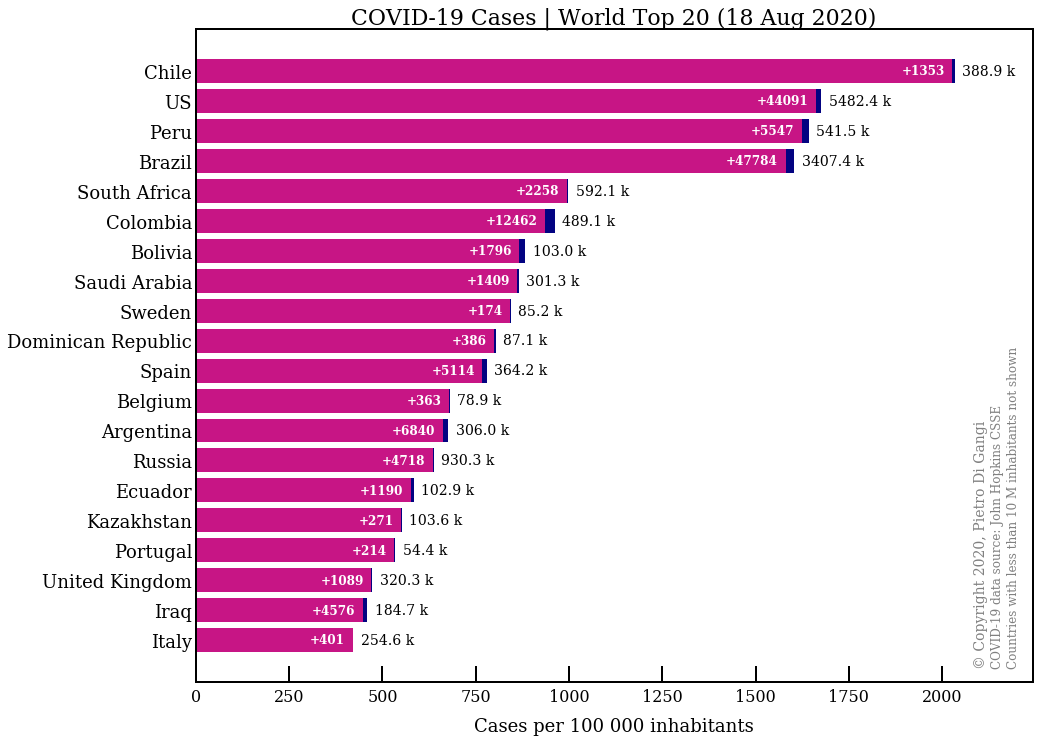

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


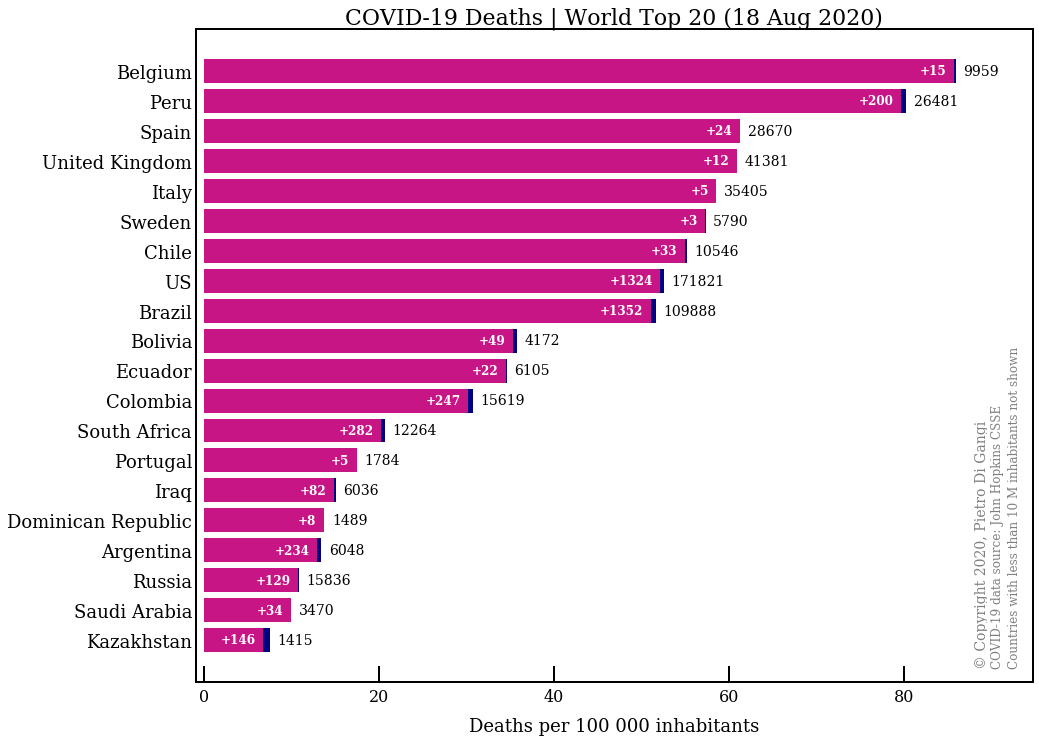

In [73]:
def standing_normalized(states, var, title='', xlabel='x', xmax=100):

    n = len(states)*0.1
    
    fig = plt.figure(figsize=(15,6*n))
    ax = fig.add_subplot(111)
    ax.tick_params(left=False) 
    states = sorted_states(states, var+'_per100k')   
    totmax = data[data.region==states[0]][var+'_per100k'].iat[-1]   
    states = states[::-1]
    
    for i,state in enumerate(states):
        df = data[data.region==state]
        pop = data.population.iat[0]
        tot = df[var].iat[-1]
        ax.barh(state, df[var+'_per100k'].iat[-1], color='navy', label='', alpha=0.99)
        for days in np.arange(1):
            ax.barh(state, df[var+'_per100k'].iat[-2-days], color='mediumvioletred', label='', alpha=1)
        lb = '%.1f k' % (tot/1000)
        if var=='deaths': lb = '%d' % (tot)
        ax.text(df[var+'_per100k'].iat[-1]+0.01*totmax, state, lb, ha='left', va='center', fontsize=14)
        ax.text(df[var+'_per100k'].iat[-2]-0.01*totmax, state, ('+%d' % df['new_'+var].iat[-1]), ha='right', va='center', color='w', fontsize=12, weight='bold')
    
    plt.xlabel(xlabel)
    ax.tick_params(axis='x', which='major', labelsize=16)
    xmax = ax.get_xlim()[1]*1.05
    ax.set_xlim(-1,xmax)
    
    #legend
    plt.title(title+' (%s)' % lastday.strftime('%-d %b %Y'), fontsize=22)
    
    # disclaimer
    text = '© Copyright 2020, Pietro Di Gangi'
    plt.text(xmax-0.07*xmax, -0.95, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=14, backgroundcolor='w')
    text = 'COVID-19 data source: John Hopkins CSSE'
    plt.text(xmax-0.05*xmax, -0.95, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12, backgroundcolor='w')
    text = 'Countries with less than 10 M inhabitants not shown'
    plt.text(xmax-0.03*xmax, -0.95, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12, backgroundcolor='w')

    plt.show()
    
    #fig.savefig('figure/%s-covid19-sicilia-contagi-normalizzati.png' % lastday.strftime('%Y-%m-%d'))
       
    
states = data[(data.population>10e6)&(data.date==lastday)].sort_values('cases_per100k', ascending=False).head(20).region.unique()
standing_normalized(states, 'cases', 'COVID-19 Cases | World Top 20', 'Cases per 100 000 inhabitants')

states = data[(data.deaths>100)&(data.population>10e6)&(data.date==lastday)].sort_values('cases_per100k', ascending=False).head(20).region.unique()
standing_normalized(states, 'deaths', 'COVID-19 Deaths | World Top 20', 'Deaths per 100 000 inhabitants')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


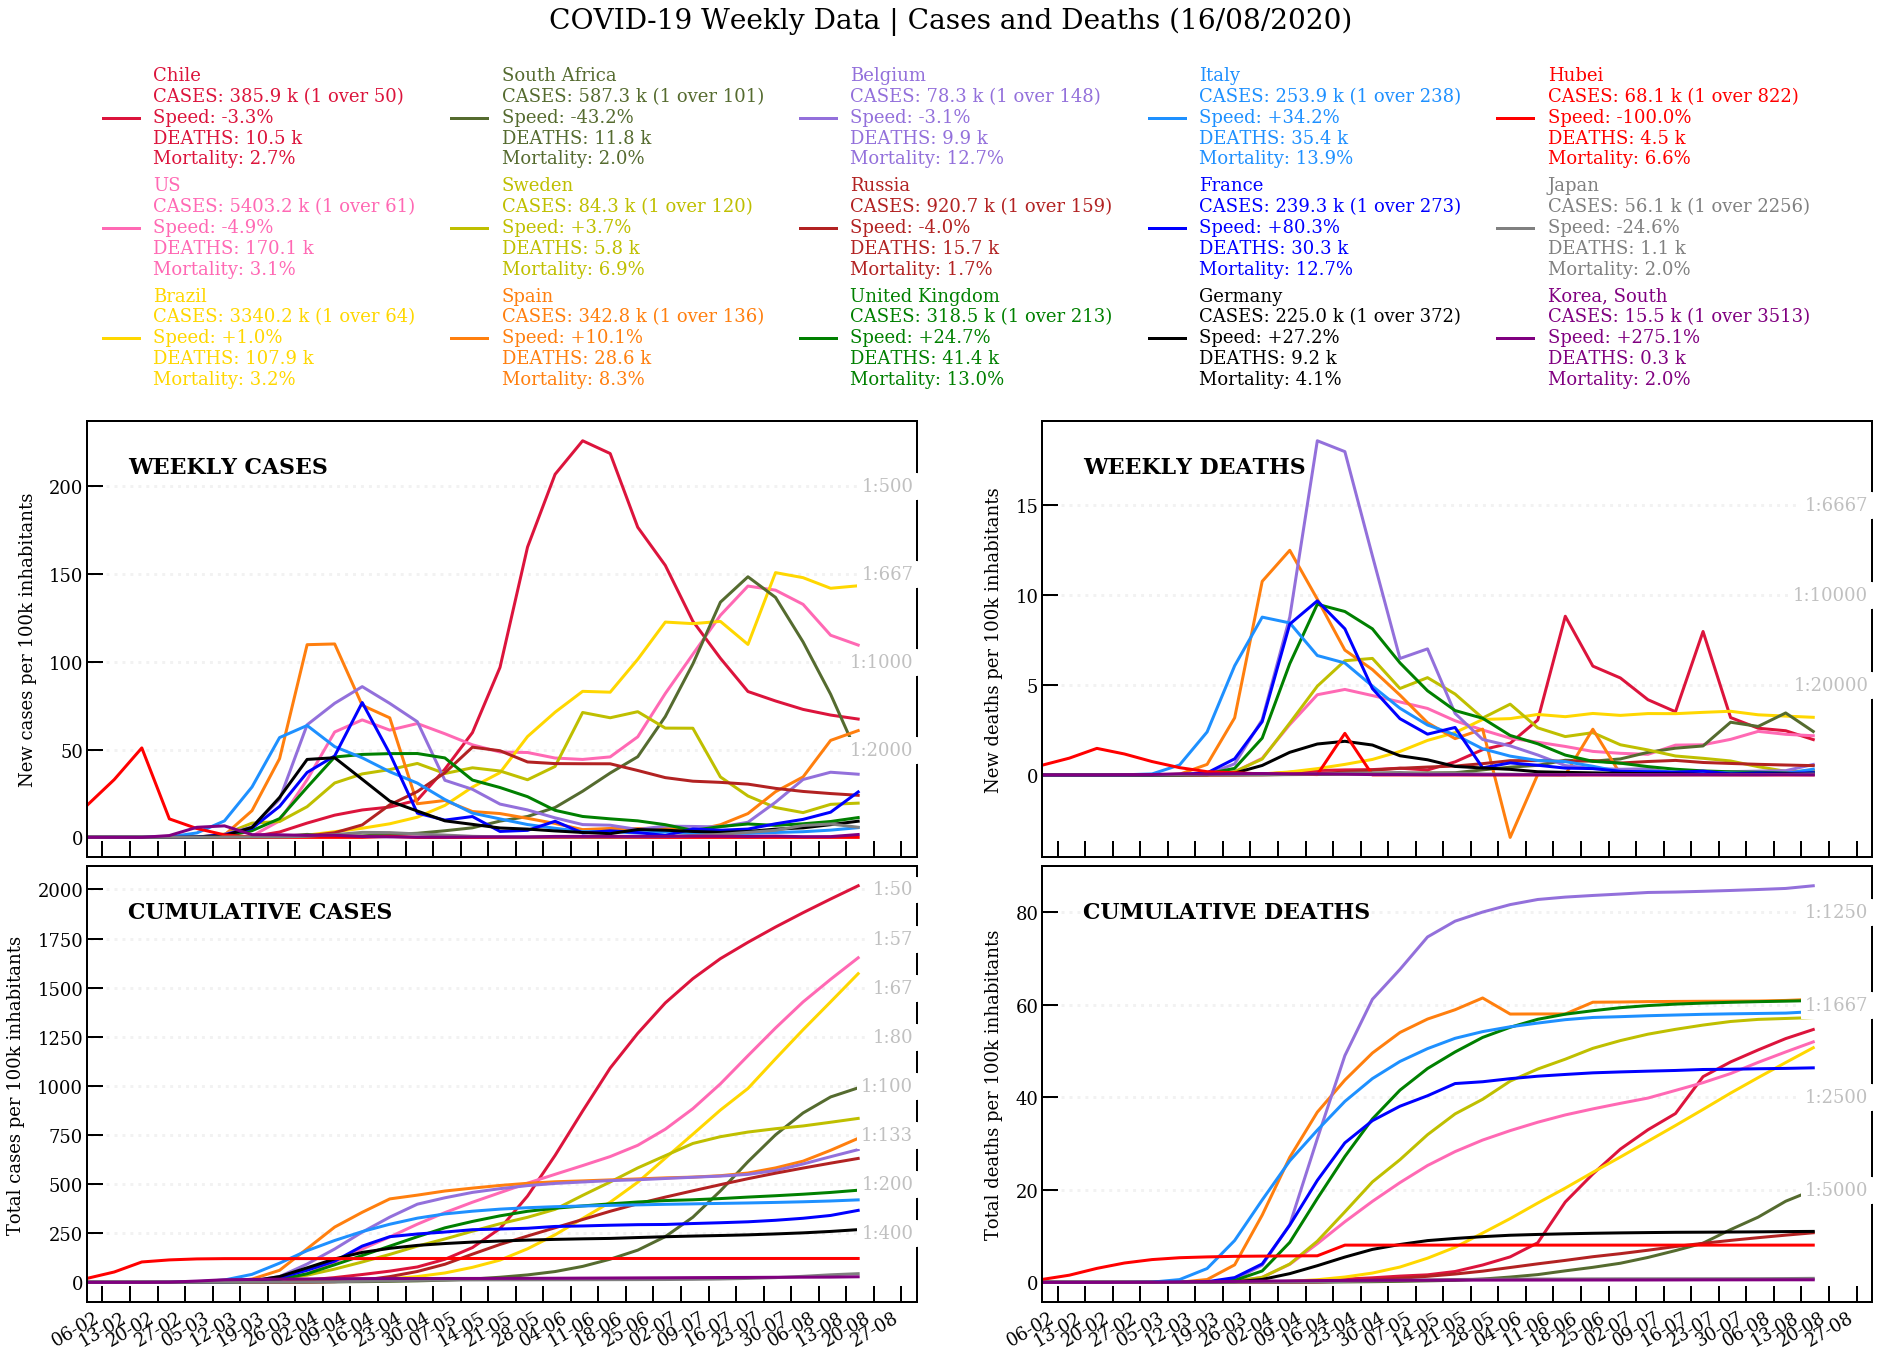

In [74]:
states = ['Sweden',
          'Brazil',
          'Russia',
          'Italy', 
          'Spain', 
          'United Kingdom', 
          'Germany', 
          'France', 
          'US', 
          'Korea, South',
          'Hubei',
          #'Iran',
          'Japan',
          #'Australia',
          'Belgium',
          #'Canada',
          #'India',
          'South Africa',
          'Chile'
         ]


fig = plt.figure(figsize=(32,18))

grid = plt.GridSpec(2, 2, hspace=0.02, wspace=0.15)
ax = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0], sharex=ax)
ax3 = fig.add_subplot(grid[0, 1])
ax4 = fig.add_subplot(grid[1, 1], sharex=ax3)


states = sorted_states_weekly(states,'cases_per100k')
for reg in states:
    df=data_weekly[data_weekly.region==reg]
    dates = df.date[1:-1]
    df_daily = data[(data.region==reg) & (data.date.isin(dates))]
    
    tot = df_daily.cases.iat[-1]
    tot_100k = df_daily.cases_per100k.iat[-1]
    if df.new_cases.iat[-3]>0:
        speed = (df.new_cases.iat[-2] - df.new_cases.iat[-3])/df.new_cases.iat[-3]*100
    else:
        speed = 0
    tot_deaths = df_daily.deaths.iat[-1]
    mortality = tot_deaths/tot*100
    lb = reg
    lb = lb + '\nCASES: %.1f k (1 over %.0f)' % (tot/1e3, 1e5/tot_100k)
    lb = lb + '\nSpeed: %+.1f%s' % (speed, '%')
    lb = lb + '\nDEATHS: %.1f k' % (tot_deaths/1e3)
    lb = lb + '\nMortality: %.1f%s' % (mortality, '%')
    
    ax.plot(df.date[1:-1],df.new_cases_per100k[1:-1], label=lb, color=color[reg])
    ax3.plot(df.date[1:-1],df.new_deaths_per100k[1:-1], label=lb, color=color[reg])
    ax2.plot(dates,df_daily.cases_per100k, label=lb, color=color[reg])
    ax4.plot(dates,df_daily.deaths_per100k, label='', color=color[reg])
    
    
  
ax.set_xlim(dates.iat[0], dates.iat[-1]+timedelta(days=15))
ax3.set_xlim(dates.iat[0], dates.iat[-1]+timedelta(days=15))

leg = ax.legend(ncol=5, loc='upper left', bbox_to_anchor=(0,1.85), fontsize=18, frameon=False)
leglabels_style()



for axx in [ax,ax2,ax3,ax4]:
    axx.autoscale(False) 
    locs = axx.get_yticks()
    for y in [i for i in locs[1:-1] if i > 0]:
        axx.hlines(y,datetime.date(2019,1,1),datetime.date(2021,1,1), color='k', linestyles=':', alpha=0.05)
        t = axx.text(dates.iat[-1]+timedelta(days=14), y, '1:%.0f' % (1./y*1e5), ha='right', va='center', color='silver')
        t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))


ax.text(0.05, .92, 'WEEKLY CASES', fontsize=22, weight='bold', ha='left', va='top', transform=ax.transAxes)
ax.set_ylabel('New cases per 100k inhabitants')
ax2.text(0.05, .92, 'CUMULATIVE CASES', fontsize=22, weight='bold', ha='left', va='top', transform=ax2.transAxes)
ax2.set_ylabel('Total cases per 100k inhabitants')
ax3.text(0.05, .92, 'WEEKLY DEATHS', fontsize=22, weight='bold', ha='left', va='top', transform=ax3.transAxes)
ax3.set_ylabel('New deaths per 100k inhabitants')
ax4.text(0.05, .92, 'CUMULATIVE DEATHS', fontsize=22, weight='bold', ha='left', va='top', transform=ax4.transAxes)
ax4.set_ylabel('Total deaths per 100k inhabitants')
        
        
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.tick_params(axis='x', which='major', labelsize=16)
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax3.tick_params(axis='x', which='major', labelsize=16)



fig.autofmt_xdate()
plt.gcf().autofmt_xdate()


plt.suptitle('COVID-19 Weekly Data | Cases and Deaths (%s)' % lastday_weekly.strftime('%-d/%m/%Y'), fontsize=28, y=1.2)


plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


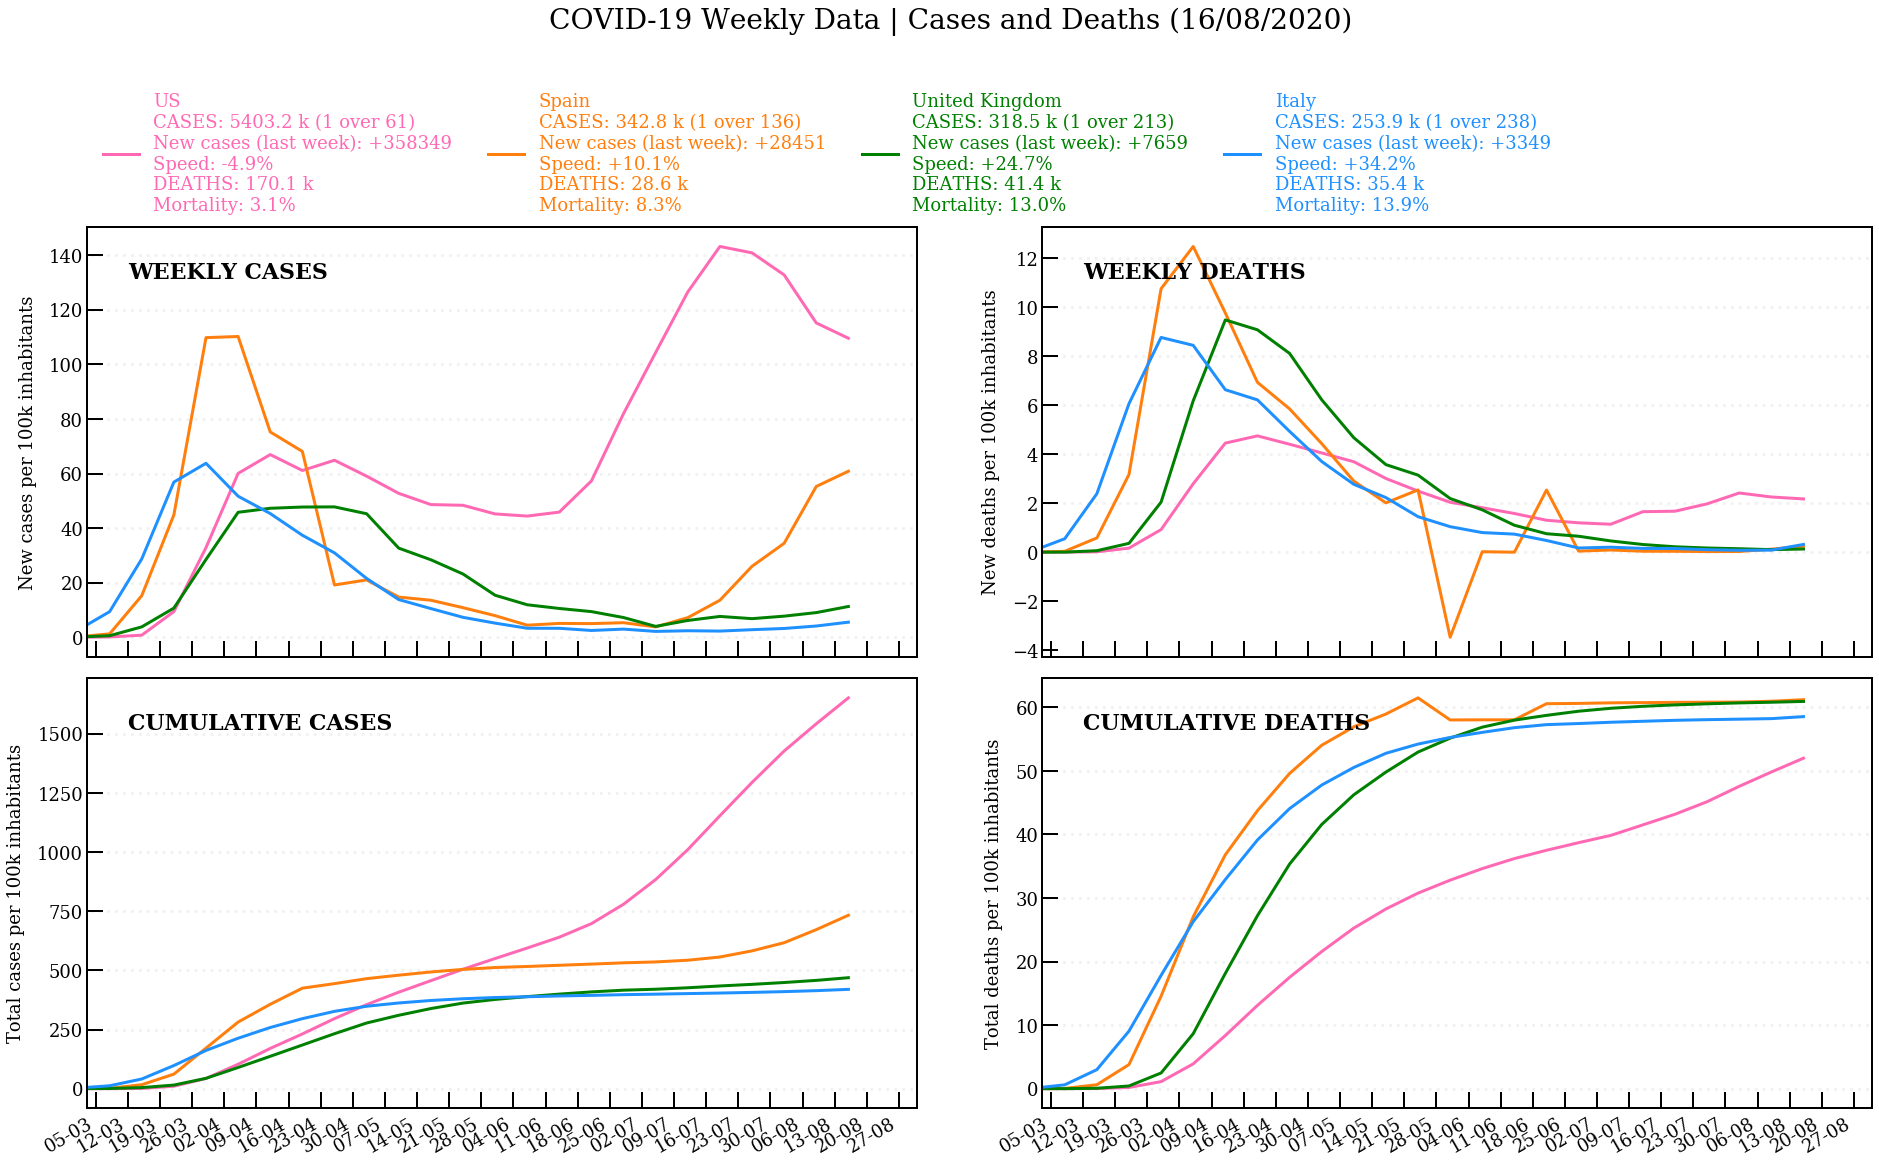

In [75]:
states = [#'Sweden',
          #'Brazil',
          'US',
          'Italy',  
          'United Kingdom',
          'Spain',
          #'Germany', 
          #'France', 
          #'Korea, South',
          #'Hubei',
          #'Iran',
          #'Japan',
          #'Australia',
          #'Belgium',
          #'Canada',
          #'India',
          #'South Africa',
          #'Chile'
         ]


fig = plt.figure(figsize=(32,18))

grid = plt.GridSpec(2, 2, hspace=0.05, wspace=0.15)
ax = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0], sharex=ax)
ax3 = fig.add_subplot(grid[0, 1])
ax4 = fig.add_subplot(grid[1, 1], sharex=ax3)


states = sorted_states_weekly(states,'cases_per100k')
for reg in states:
    df=data_weekly[data_weekly.region==reg]
    dates = df.date[1:-1]
    df_daily = data[(data.region==reg) & (data.date.isin(dates))]
    
    tot = df_daily.cases.iat[-1]
    tot_100k = df_daily.cases_per100k.iat[-1]
    if df.new_cases.iat[-3]>0:
        speed = (df.new_cases.iat[-2] - df.new_cases.iat[-3])/df.new_cases.iat[-3]*100
    else:
        speed = 0
    tot_deaths = df_daily.deaths.iat[-1]
    mortality = tot_deaths/tot*100
    lb = reg
    lb = lb + '\nCASES: %.1f k (1 over %.0f)' % (tot/1e3, 1e5/tot_100k)
    lb = lb + '\nNew cases (last week): +%d' % (df.new_cases.iat[-2])
    lb = lb + '\nSpeed: %+.1f%s' % (speed, '%')
    lb = lb + '\nDEATHS: %.1f k' % (tot_deaths/1e3)
    lb = lb + '\nMortality: %.1f%s' % (mortality, '%')
    
    ax.plot(df.date[1:-1],df.new_cases_per100k[1:-1], label=lb, color=color[reg])
    ax3.plot(df.date[1:-1],df.new_deaths_per100k[1:-1], label=lb, color=color[reg])
    ax2.plot(dates,df_daily.cases_per100k, label=lb, color=color[reg])
    ax4.plot(dates,df_daily.deaths_per100k, label='', color=color[reg])
    
    
  
ax.set_xlim(dates.iat[0]+timedelta(days=30), dates.iat[-1]+timedelta(days=15))
ax3.set_xlim(dates.iat[0]+timedelta(days=30), dates.iat[-1]+timedelta(days=15))

leg = ax.legend(ncol=5, loc='upper left', bbox_to_anchor=(0,1.35), fontsize=18, frameon=False)
leglabels_style()



for axx in [ax,ax2,ax3,ax4]:
    axx.autoscale(False) 
    locs = axx.get_yticks()
    for y in [i for i in locs[1:-1] if i >= 0]:
        axx.hlines(y,datetime.date(2019,1,1),datetime.date(2021,1,1), color='k', linestyles=':', alpha=0.05)
        #t = axx.text(dates.iat[-1]+timedelta(days=14), y, '1:%.0f' % (1./y*1e5), ha='right', va='center', color='silver')
        #t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))

ax.text(0.05, .92, 'WEEKLY CASES', fontsize=22, weight='bold', ha='left', va='top', transform=ax.transAxes)
ax.set_ylabel('New cases per 100k inhabitants')
ax2.text(0.05, .92, 'CUMULATIVE CASES', fontsize=22, weight='bold', ha='left', va='top', transform=ax2.transAxes)
ax2.set_ylabel('Total cases per 100k inhabitants')
ax3.text(0.05, .92, 'WEEKLY DEATHS', fontsize=22, weight='bold', ha='left', va='top', transform=ax3.transAxes)
ax3.set_ylabel('New deaths per 100k inhabitants')
ax4.text(0.05, .92, 'CUMULATIVE DEATHS', fontsize=22, weight='bold', ha='left', va='top', transform=ax4.transAxes)
ax4.set_ylabel('Total deaths per 100k inhabitants')
        
        
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.tick_params(axis='x', which='major', labelsize=16)
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax3.tick_params(axis='x', which='major', labelsize=16)



fig.autofmt_xdate()
plt.gcf().autofmt_xdate()


plt.suptitle('COVID-19 Weekly Data | Cases and Deaths (%s)' % lastday_weekly.strftime('%-d/%m/%Y'), fontsize=28, y=1.05)


plt.show()

In [76]:
def guideline(ax, xlim=(0,1), ylim=(0,1), m=1, label=''):
    xmin = xlim[0]
    xmax = xlim[1]
    ymin = ylim[0]
    ymax = ylim[1]
    ax.plot((0,xmax), (0,m*xmax), ls='--', lw=1, color='silver', zorder=-100)

    mplot = (ymax-ymin)/(xmax-xmin)
    if m < mplot:
        coord = [0.85*xmax, 0.85*xmax*m]
    else:
        coord = [0.85*ymax/m, 0.85*ymax]
    label = '%.f%s ' % (m*100, '%') + label
    ax.text(coord[0], coord[1], label, color='silver', fontsize=12, rotation=np.rad2deg(np.arctan(m/mplot)), ha='center', va='center', backgroundcolor='w', zorder=-100)

def trailplot(regions, ndays, varx, vary, xlabel, ylabel, xlim, ylim, guidelines, gl_label):
    #sorted_df = data[data.region.isin(regions)][data.date==lastday].sort_values(varx)
    #regions = sorted_df.region.unique()

    # Set up the axes with gridspec
    fig = plt.figure(figsize=(14,14))
    grid = plt.GridSpec(4, 4, hspace=0., wspace=0.)
    ax = fig.add_subplot(grid[:-1, 1:])
    y_ax = fig.add_subplot(grid[:-1, 0], xticks=[], sharey=ax)
    x_ax = fig.add_subplot(grid[-1, 1:], sharex=ax)
    x_ax.tick_params(axis='y', which='major', labelsize=14)
    ax.tick_params(labelbottom=False, labelleft=False)



    # plot curves
    days = np.arange(1,ndays)
    mk = 'o'
    ms=200
    #dummy points
    #x_ax.scatter(0,'',label='', color='w', marker=mk, s=ms)
    y_ax.scatter('',0,label='', color='w', marker=mk, s=ms)

    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        pop = df['population'].iat[0]
        #ax.scatter(df[varx].iat[-1]/pop*1e5, df[vary].iat[-1]/pop*1e5, label='', color=color, marker=mk, s=ms)
        #x_ax.scatter(x,state,label='', color=color, marker=mk, s=ms, alpha=alpha)
        #y_ax.scatter(state,y,label='', color=color, marker=mk, s=ms, alpha=alpha)
        for day in list(reversed(days)):
            x = df[varx].iat[-day]/pop*1e5 # total value 'day' ago
            y = df[vary].iat[-day]/pop*1e5
            alpha = 1./day
            ax.scatter(x,y,label='', color=color[reg], marker=mk, s=ms, alpha=alpha)
            x_ax.scatter(x,reg,label='', color=color[reg], marker=mk, s=ms, alpha=alpha)
            y_ax.scatter(reg,y,label='', color=color[reg], marker=mk, s=ms, alpha=alpha)
        #x_ax.text(x+0.03*xlim[1], reg, '%d (+%d)' % (df[varx].iat[-1], df['new_'+varx].iat[-1]), ha='left', va='center', fontsize=11)
        #y_ax.text(reg, y+0.03*ylim[1], '%d (+%d)' % (df[vary].iat[-1], df['new_'+vary].iat[-1]), ha='center', va='bottom', fontsize=11, rotation=90)

    # axes
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    x_ax.set_xlim(xlim)
    y_ax.set_ylim(ylim)
    y_ax.set_ylabel(ylabel+' per 100 000 inhabitants')
    x_ax.set_xlabel(xlabel+' per 100 000 inhabitants')

    # mortality guidelines
    for m in guidelines:
        guideline(ax=ax, xlim=xlim, ylim=ylim, m=m, label=gl_label)

    #legend
    #leg = ax.legend(loc=0, frameon=True, ncol=1, 
    ax.set_title('COVID-19 | Last %d days (Updated %s)' % (ndays, lastday.strftime('%-d %b %Y')))
    #leglabels_style()

    plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


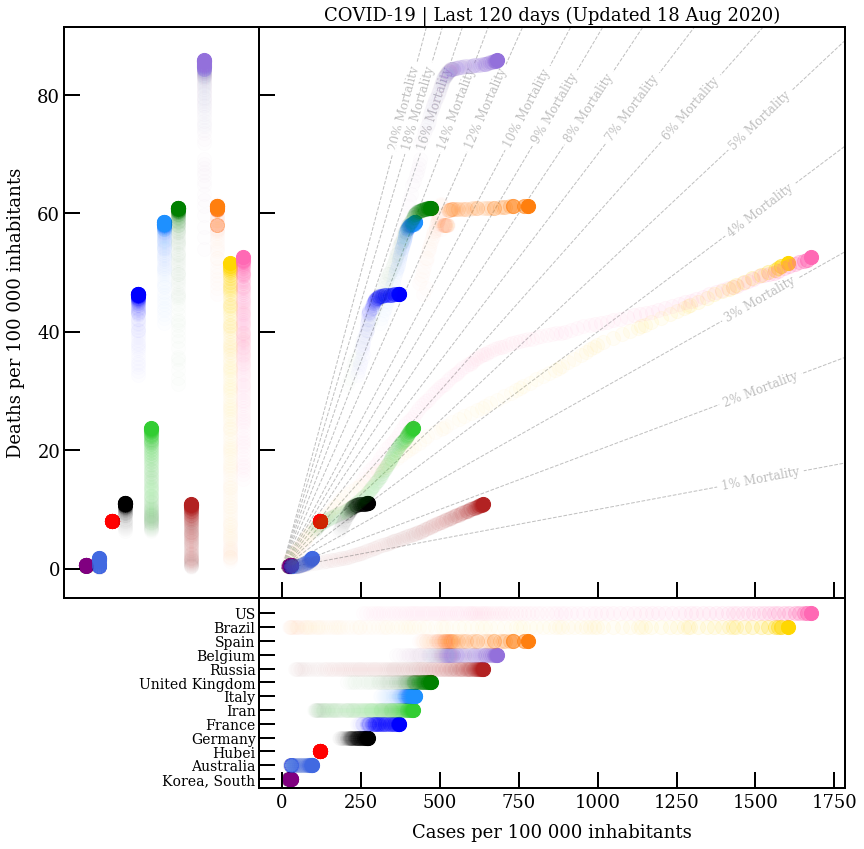

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


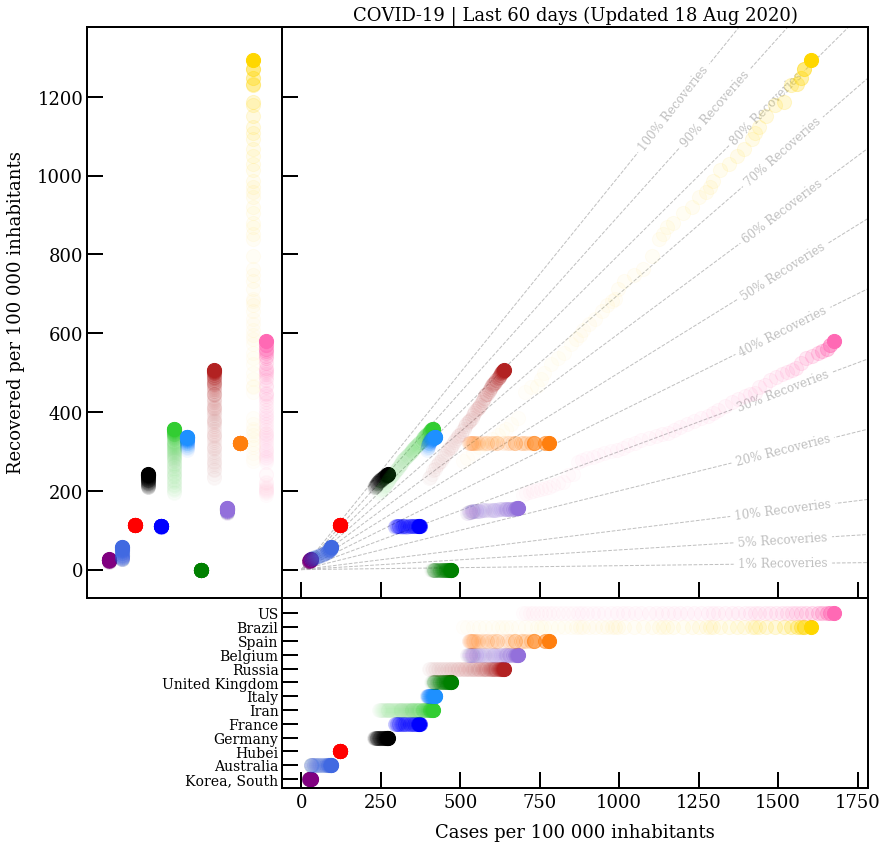

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


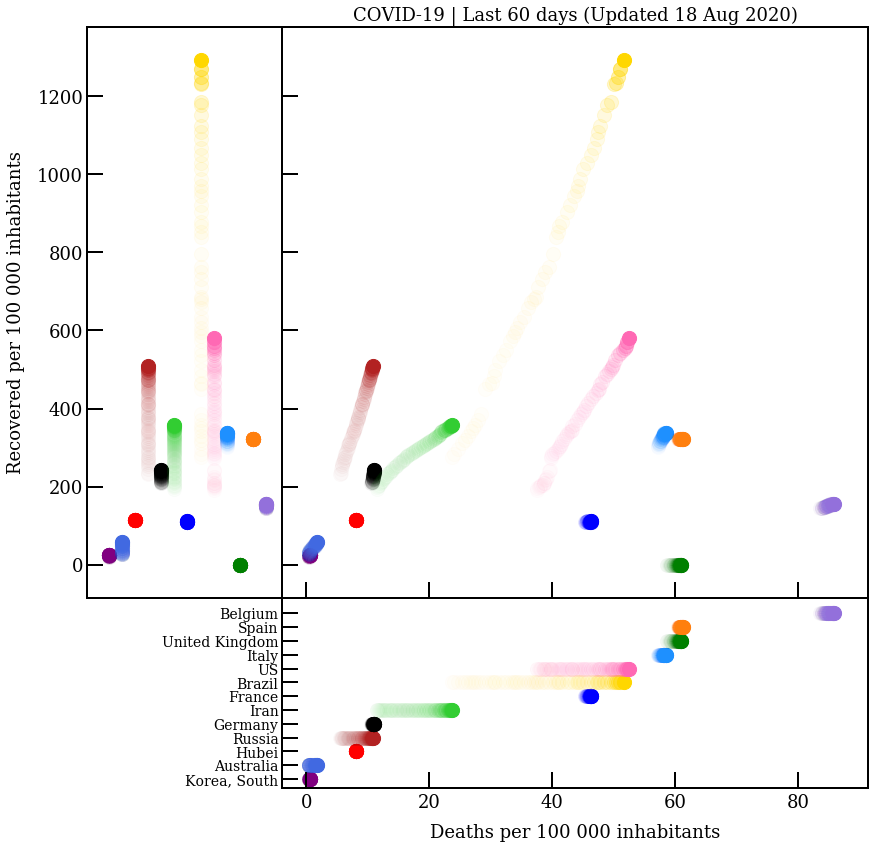

In [77]:
# Cases vs Deaths
states = ['Belgium','Brazil','Russia','Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South', 'Australia', 'Iran']
states = data[data.region.isin(states)][data.date==lastday].sort_values('cases_per100k').region.unique()
#print(states)
trailplot(regions=states, ndays=120,
          varx='cases', vary='deaths', xlabel='Cases', ylabel='Deaths',
          xlim=(-15,380), ylim=(-1,40), guidelines=[0.2,0.18,0.16,0.14,0.12,0.1,0.09,0.08,0.07,0.06,0.05,0.03,0.04,0.02,0.01], gl_label='Mortality',
         )

# Cases vs Recovered
states = data[data.region.isin(states)][data.date==lastday].sort_values('cases_per100k').region.unique()
trailplot(regions=states, ndays=60,
          varx='cases', vary='recovered', xlabel='Cases', ylabel='Recovered',
          xlim=(-15,380), ylim=(-3,119), guidelines=[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01,], gl_label='Recoveries',
         )

# Deaths vs Recovered
states = data[data.region.isin(states)][data.date==lastday].sort_values('deaths_per100k').region.unique()
trailplot(regions=states, ndays=60,
          varx='deaths', vary='recovered', xlabel='Deaths', ylabel='Recovered',
          xlim=(-1,40), ylim=(-3,119), guidelines=[], gl_label='',
         )

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


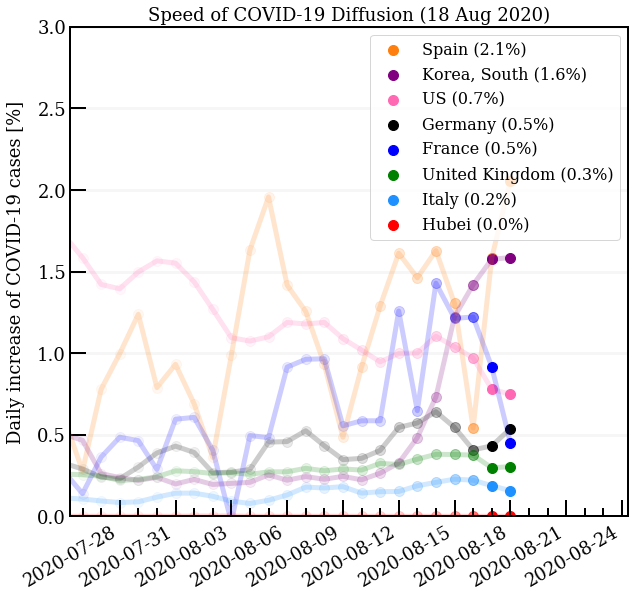

In [78]:
var = 'cases_delta3'
states = ['Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

#lockdown lines
#lockdown_lines()

# sort by most cases
states = sorted_states(states, var)

# plot curves
for state in states:
    df = data[data.region==state]    
    ax.plot(df.date, df[var]*100, label='', color=color[state], lw=5, alpha=0.2)

ndays = 30
days = np.arange(1,ndays) 
mk='o'
ms=100
for state in states:
    df = data[data.region==state]
    tot = df[var].iat[-1]*100 # total value at current date
    pop = df.population.iat[0]
    label = state + ' (%.1f%s)' % (tot,'%')
    ax.scatter(df.date.iat[-1], df[var].iat[-1]*100, label=label, color=color[state], marker=mk, s=ms)
    for day in list(reversed(days)):
        x = df['date'].iat[-1-day] # total value 'day' ago
        y = df[var].iat[-1-day]*100
        alpha = 1/day
        ax.scatter(x,y,label='', color=color[state], marker=mk, s=ms, alpha=alpha)

# axes
format_dateaxis()
ax.set_xlim([today-timedelta(days=ndays), today+timedelta(days=0)])
ax.set_ylim(0,3)
plt.ylabel('Daily increase of COVID-19 cases [%]')
#plt.xscale('log')
plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = plt.legend(loc=0, frameon=True)
plt.title('Speed of COVID-19 Diffusion (%s)' % lastday.strftime('%-d %b %Y'))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


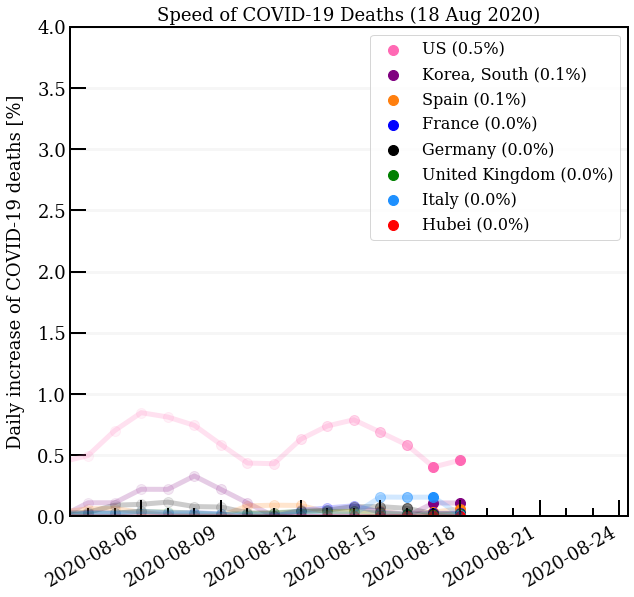

In [79]:
var = 'deaths_delta3'
states = ['Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

#lockdown lines
#lockdown_lines()

# sort by most cases
states = sorted_states(states, var)

# plot curves
for state in states:
    df = data[data.region==state]    
    ax.plot(df.date, df[var]*100, label='', color=color[state], lw=5, alpha=0.2)

ndays = 21
days = np.arange(1,ndays) 
mk='o'
ms=100
for state in states:
    df = data[data.region==state]
    tot = df[var].iat[-1]*100 # total value at current date
    df.population.iat[0]
    label = state + ' (%.1f%s)' % (tot,'%')
    ax.scatter(df.date.iat[-1], df[var].iat[-1]*100, label=label, color=color[state], marker=mk, s=ms)
    for day in list(reversed(days)):
        x = df['date'].iat[-1-day] # total value 'day' ago
        y = df[var].iat[-1-day]*100
        alpha = 1/day
        ax.scatter(x,y,label='', color=color[state], marker=mk, s=ms, alpha=alpha)

# axes
format_dateaxis()
ax.set_xlim([today-timedelta(days=ndays), today+timedelta(days=0)])
ax.set_ylim(0,4)
plt.ylabel('Daily increase of COVID-19 deaths [%]')
plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = plt.legend(loc=0, frameon=True)
plt.title('Speed of COVID-19 Deaths (%s)' % lastday.strftime('%-d %b %Y'))
leglabels_style()

plt.show()